In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from smart_open import open
import pprint
import gensim
#import gensim.downloader as api
from gensim import corpora
from gensim.utils import simple_preprocess 
from gensim import models 
from gensim.models import TfidfModel

import nltk
from nltk import word_tokenize
from nltk import downloader
nltk.download('punkt')

import string
import re
from nltk.corpus import stopwords
nltk.download('stopwords')

from nltk.stem.porter import PorterStemmer
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger')

from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

import heapq 

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\donag\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\donag\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\donag\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\donag\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
#df = pd.read_csv("./input/Mall_Customers.csv")
df = pd.read_csv("./input/covid.csv")

In [3]:
df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,1,44953,NYC,02-03-2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative
1,2,44954,"Seattle, WA",02-03-2020,When I couldn't find hand sanitizer at Fred Me...,Positive
2,3,44955,NaN,02-03-2020,Find out how you can protect yourself and love...,Extremely Positive
3,4,44956,Chicagoland,02-03-2020,#Panic buying hits #NewYork City as anxious sh...,Negative
4,5,44957,"Melbourne, Victoria",03-03-2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral


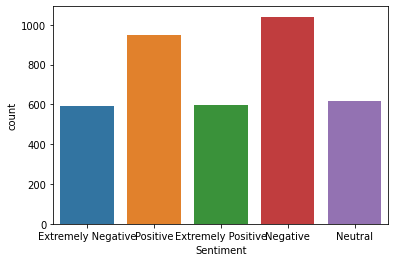

In [4]:
ax = sns.countplot(x="Sentiment", data=df)

In [5]:
train = df.OriginalTweet
train.head(3)

0    TRENDING: New Yorkers encounter empty supermar...
1    When I couldn't find hand sanitizer at Fred Me...
2    Find out how you can protect yourself and love...
Name: OriginalTweet, dtype: object

In [6]:
train.shape

(3798,)

In [7]:
#train = df.OriginalTweet
train.to_numpy()
train[:2]

0    TRENDING: New Yorkers encounter empty supermar...
1    When I couldn't find hand sanitizer at Fred Me...
Name: OriginalTweet, dtype: object

# NLP

In [ ]:
# define lemmatizer, stop words and string
wordnet_lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
string.punctuation

In [ ]:
# TEXT PREPROCESSING FUNCTION
def prep(x):
    X_p = []
    for sp in x:
        sp = re.sub(r'\d+', '', str(sp))
        sp = re.sub(r'https?:\/\/.*[\r\n]*', '', str(sp), flags=re.MULTILINE)
        sp = "".join([char for char in sp if char not in string.punctuation])
        spl = sp.lower()
        sps = re.sub('\s+', ' ', spl).strip()
        word_tokens = word_tokenize(sps)
        filtered_result = list(filter(lambda l: l not in stop_words, word_tokens))
        lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result]
        
        X_p.append(lemmas)
    return X_p

In [ ]:
X = prep(train)
X[:2]

In [ ]:
# number of documents/lists inside the Main List
len(X)

In [ ]:
# function prepare "main list of documents" with this function for the Gensim doc2vec model
def tagged_document(list_of_list_of_words):
    for i, list_of_words in enumerate(list_of_list_of_words):
        yield gensim.models.doc2vec.TaggedDocument(list_of_words, [i])

In [ ]:
# process "main list of documents" for the Gensim doc2vec model
data_for_training = list(tagged_document(X))
print(data_for_training[:1])

In [ ]:
len(data_for_training)

# Building our Doc2Vec using Gensim

In [ ]:
model = gensim.models.doc2vec.Doc2Vec(vector_size=1000, min_count=2, epochs=20)
model.build_vocab(data_for_training)
model.train(data_for_training, total_examples=model.corpus_count, epochs=model.epochs)

In [ ]:
#save model vectors to a variable
vectors = model.wv

In [ ]:
#explore word similarities using our vector space
print(vectors.similarity('good', 'take'))
print(vectors.similarity('good', 'true'))

In [ ]:
# find words most similar or close to the word go
vectors.most_similar('go')

In [ ]:
len(model.wv.vocab)

In [ ]:
# build a list of the terms, integer indices,
# and term counts from the doc2vec model vocabulary
ordered_vocab = [(term, voc.index, voc.count) for term, voc in model.wv.vocab.items()]

# sort by the term counts, so the most common terms appear first
ordered_vocab = sorted(ordered_vocab, key=lambda k: -k[2])

# unzip the terms, integer indices, and counts into separate lists
ordered_terms, term_indices, term_counts = zip(*ordered_vocab)

# create a DataFrame with the doc2vec vectors as data,
# and the terms as row labels
word_vectors = pd.DataFrame(model.wv.syn0norm[term_indices, :], index=ordered_terms)

In [ ]:
# Transpose document vector
word_vectorst = word_vectors.T

In [ ]:
# display head of our document vector space
word_vectorst.head()

In [ ]:
word_vectorst.shape

In [11]:
def PCA(X , num_components):
     
    #Step-1
    X_meaned = X - np.mean(X , axis = 0)
     
    #Step-2
    cov_mat = np.cov(X_meaned , rowvar = False)
     
    #Step-3
    eigen_values , eigen_vectors = np.linalg.eigh(cov_mat)
     
    #Step-4
    sorted_index = np.argsort(eigen_values)[::-1]
    sorted_eigenvalue = eigen_values[sorted_index]
    sorted_eigenvectors = eigen_vectors[:,sorted_index]
     
    #Step-5
    eigenvector_subset = sorted_eigenvectors[:,0:num_components]
     
    #Step-6
    X_reduced = np.dot(eigenvector_subset.transpose() , X_meaned.transpose() ).transpose()
     
    return X_reduced

In [18]:
#Applying PCA function
mat_reduced = PCA(word_vectorst, 2)
 
# #Creating a Pandas DataFrame of reduced Dataset
principal_df = pd.DataFrame(mat_reduced , columns = ['PC1','PC2'])

In [13]:
print(principal_df)

           PC1        PC2
0   -31.870508 -33.001425
1     0.763397 -56.843865
2   -57.408726 -13.122936
3    -2.169896 -53.477905
4   -32.174920 -30.387005
..         ...        ...
195  58.353072  31.016926
196  19.909355  66.446425
197  58.521858  38.343853
198  20.981105  79.375146
199  72.448826  41.808833

[200 rows x 2 columns]


In [19]:
db_data = principal_df.to_numpy()
#xa = dfe.to_numpy()

In [15]:
from pyclustering.cluster.dbscan import dbscan
from pyclustering.cluster import cluster_visualizer
from pyclustering.utils import read_sample
from pyclustering.samples.definitions import FCPS_SAMPLES

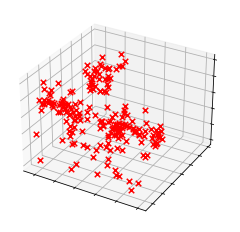

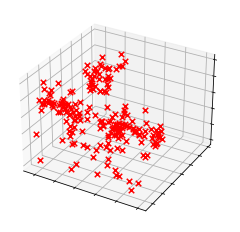

In [20]:
dbscan_instance = dbscan(xa, 0.7, 3)

# Start processing by DBSCAN.
dbscan_instance.process()

# Obtain results of clustering.
clusters = dbscan_instance.get_clusters()
noise = dbscan_instance.get_noise()

# Visualize clustering results
visualizer = cluster_visualizer()
visualizer.append_clusters(clusters, xa)

visualizer.append_cluster(noise, xa, marker='x')
visualizer.show()